In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hyperion.model import ModelOutput
import astropy.units as u
import h5py
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

from astropy.io import fits
from astropy.convolution import convolve_fft
from astropy.cosmology import Planck13
from astropy import constants
from astropy.modeling import models
import json
import yt
import ytree
from scipy.optimize import curve_fit

/storage/home/hcoda1/7/shardin31/.conda/envs/pd_environment_3/lib/python3.8/site-packages/Hyperion-0.0.0-py3.8-linux-x86_64.egg/hyperion/model/analytical_yso_model.py:496: SyntaxWarning: "is" with a literal. Did you mean "=="?
/storage/home/hcoda1/7/shardin31/.conda/envs/pd_environment_3/lib/python3.8/site-packages/Hyperion-0.0.0-py3.8-linux-x86_64.egg/hyperion/model/analytical_yso_model.py:498: SyntaxWarning: "is" with a literal. Did you mean "=="?
/storage/home/hcoda1/7/shardin31/.conda/envs/pd_environment_3/lib/python3.8/site-packages/Hyperion-0.0.0-py3.8-linux-x86_64.egg/hyperion/model/analytical_yso_model.py:575: SyntaxWarning: "is" with a literal. Did you mean "=="?
/storage/home/hcoda1/7/shardin31/.conda/envs/pd_environment_3/lib/python3.8/site-packages/Hyperion-0.0.0-py3.8-linux-x86_64.egg/hyperion/model/analytical_yso_model.py:581: SyntaxWarning: "is" with a literal. Did you mean "=="?
/storage/home/hcoda1/7/shardin31/.conda/envs/pd_environment_3/lib/python3.8/site-packages/Hy

In [2]:
def get_throughputs_filters(filter_name, m, z):
    
    thruput = []  
    wavs = []
    images = []

    with open('/storage/home/hcoda1/7/shardin31/p-jw254-0/Research/Powderday/powderday/filters/mean_throughputs_downsized/'+str(filter_name)+'_downsized.txt', 'r') as f:
        for line in f:
            wavs.append(float(line.split()[0]))
            thruput.append(float(line.split()[1]))

    for wav in wavs:
        image = m.get_image(units='ergs/s')

        iwav = np.argmin(np.abs(wav - image.wav))

        # Calculate the image width in kpc
        w = (image.x_max - image.x_min) * u.cm
        w = w.to(u.kpc)

        image = image.val[0, :, :, iwav]

        images.append(image)


    conv_image = np.zeros_like(images[0])

    images = np.asarray(images)
    thruput = np.asarray(thruput)
    wavs = np.asarray(wavs)
    c = 3e8
    
#     dl_pc = Planck13.angular_diameter_distance(z)
#     #dl_pc = Planck13.luminosity_distance(z)
#     dl_pc = dl_pc.to(u.pc)

    dl = Planck13.luminosity_distance(z)
    dl = dl.to(u.m)

    for i, image in enumerate(images):
        conv_image += image * thruput[i]

    conv_image /= thruput.sum()
    
    return(conv_image, w)


In [3]:
def surface_brightness(data, center, pixel_size):
    y, x = np.indices((data.shape))
    
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    #r = (r/2).astype(np.int) * pixel_size
    #r = r.astype(np.int) * pixel_size
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())

    radialprofile = tbin
    
    area_per_pixel = pixel_size**2
    
    nr = np.bincount(r.ravel()) * area_per_pixel

    surfacebrightness = tbin / nr

    unique_r = np.unique(r)
    unique_r = np.float64(unique_r)
    
    #get radius in kpc
    unique_r *= pixel_size    
    
    return surfacebrightness, radialprofile, unique_r

In [4]:
def sersic_profile(R, I_e, R_e, n):
    b_n = 2 * n - (1/3)  + (4/(405*n)) +  (46/(25515*n**2)) + (131/(1148175*n**3)) + (2194697/(30690717750*n**4)) # Approximation
    #b_n = 0.140403
    return I_e * np.exp(-b_n * ((R / R_e) ** (1 / n) - 1))

In [6]:
a = ytree.load("/storage/home/hcoda1/0/jw254/data/SG64-2020/rockstar_halos-jhw/trees/tree_0_0_0.dat")
m = ModelOutput('/storage/home/hcoda1/7/shardin31/p-jw254-0/Research/summer2023/pd_test/run_10000/halo_0/example.0000.rtout.image')

filename = '/storage/home/hcoda1/0/jw254/data/SG64-2020/DD0125/output_0125'
ds = yt.load(filename)
z = ds.current_redshift


filters = ['F070W', 'F090W', 'F115W', 'F150W', 'F200W', 'F277W', 'F356W', 'F444W']

for filter_name in filters:
    #get image over wavelength range of filters
    conv_image, width = get_throughputs_filters(filter_name, m, z)
    width = width / u.kpc

    #find radial profile
    nx, ny = conv_image.shape
    center = (nx / 2, ny /2)

    pixel_size = width/conv_image.shape[0]
    surf_brightness, rad_profile, r = surface_brightness(conv_image, center, pixel_size)

    cumulative_sum = np.cumsum(rad_profile)

    half_light = cumulative_sum[-1] * 0.5

    #find half light radius which is also major and minor axis for sersic profile; also all the info we need about statistics of size
    half_light_rad = np.interp(half_light, cumulative_sum, r)

    #guesses for variable we want to fit (n)
    p0 = [2]

    I_e = half_light
    R_e = half_light_rad

    ppot, pcov = curve_fit(lambda R, n: sersic_profile(R, I_e, R_e, n), r, surf_brightness, p0 = p0)
    
    sersic_index = ppot[0]
    print(ppot[0])


yt : [INFO     ] 2025-04-01 17:28:04,381 Parameters: current_time              = 75.89987395114
yt : [INFO     ] 2025-04-01 17:28:04,382 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-04-01 17:28:04,383 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-04-01 17:28:04,384 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-04-01 17:28:04,385 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-04-01 17:28:04,385 Parameters: current_redshift          = 11.181356517874
yt : [INFO     ] 2025-04-01 17:28:04,385 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2025-04-01 17:28:04,386 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2025-04-01 17:28:04,386 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-04-01 17:28:04,387 Parameters: hubble_constant           = 0.6766
/tmp/ipykernel_1046178/1424154734.py:7: DeprecationWarning: `np.int` is a deprecated alias for the bu

2.0
2.0
2.0
1.090011511823041
1.0101124502702221
1.058203425262751
1.0807995232826266
1.082363278132285


In [26]:
conv_image, width = get_throughputs_filters("F356W", m, z)

In [18]:
y, x = np.indices((conv_image.shape))

print("y:", y)

y: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
    1   1   1   1   1   

In [19]:
virial_radius = a["virial_radius"][0].to("kpc")*a["scale"][0]
nx, ny = conv_image.shape
center = (nx / 2, ny /2)

In [27]:
r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
r = r.astype(np.int)

tbin = np.bincount(r.ravel(), conv_image.ravel())

radialprofile = tbin

unique_r = np.unique(r)
# unique_r = np.float64(np.unique(r))
# print(np.float64(unique_r))
unique_r *= pixel_size
print(unique_r)

/tmp/ipykernel_3110519/3447397609.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = r.astype(np.int)


UFuncTypeError: Cannot cast ufunc 'multiply' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [6]:
a = ytree.load("/storage/home/hcoda1/0/jw254/data/SG64-2020/rockstar_halos-jhw/trees/tree_0_0_0.dat")
m = ModelOutput('/storage/home/hcoda1/7/shardin31/p-jw254-0/Research/summer2023/pd_test/run_10000/halo_0/example.0000.rtout.image')

filename = '/storage/home/hcoda1/0/jw254/data/SG64-2020/DD0125/output_0125'
ds = yt.load(filename)
z = ds.current_redshift

filter_name = "F356W"

conv_image, width = get_throughputs_filters(filter_name, m, z)
width = width / u.kpc

#find radial profile
#virial_radius = a["virial_radius"][0].to("kpc")*a["scale"][0]
nx, ny = conv_image.shape
center = (nx / 2, ny /2)

pixel_size = width/conv_image.shape[0]
surf_brightness, rad_profile, r = surface_brightness(conv_image, center, pixel_size)

# mask = rad_profile > 0  # Create a mask where r is less than or equal to 0.8
# r = r[mask]
# rad_profile = rad_profile[mask]

#     valid = (rad_profile > 0) & np.isfinite(rad_profile)
#     r_new, rad_profile_new = r[valid], rad_profile[valid]

#     if r_new.size and rad_profile_new.size > 0:

# print(rad_profile)
# print(r)

cumulative_sum = np.cumsum(rad_profile)

half_light = cumulative_sum[-1] * 0.5

#find half light radius which is also major and minor axis for sersic profile
half_light_rad = np.interp(half_light, cumulative_sum, r)

# index = np.argmin(np.abs(r - half_light_rad))
# half_light_actual = rad_profile[index]

#guesses for variable we want to fit (n)
p0 = [2]

I_e = half_light
R_e = half_light_rad

#new_sersic_fxn = lambda R, n: sersic_profile(R, I_e, R_e, n)

ppot, pcov = curve_fit(lambda R, n: sersic_profile(R, I_e, R_e, n), r, surf_brightness, p0 = p0)

#print(filter_name, rad_profile_new)

print(filter_name, ppot)
print("covariance", pcov)
print("standard deviation", np.sqrt(pcov))

Additional features and improved performance (usually) by saving this arbor with "save_arbor" and reloading:
	>>> a = ytree.load("/storage/home/hcoda1/0/jw254/data/SG64-2020/rockstar_halos-jhw/trees/tree_0_0_0.dat")
	>>> fn = a.save_arbor()
	>>> a = ytree.load(fn)


yt : [INFO     ] 2025-03-27 11:35:23,417 Parameters: current_time              = 75.89987395114
yt : [INFO     ] 2025-03-27 11:35:23,418 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-03-27 11:35:23,419 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-03-27 11:35:23,420 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-03-27 11:35:23,421 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-03-27 11:35:23,421 Parameters: current_redshift          = 11.181356517874
yt : [INFO     ] 2025-03-27 11:35:23,422 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2025-03-27 11:35:23,422 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2025-03-27 11:35:23,422 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-03-27 11:35:23,423 Parameters: hubble_constant           = 0.6766


F356W [1.08079952]
covariance [[1.11799732]]
standard deviation [[1.05735392]]


/tmp/ipykernel_2506663/1424154734.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = r.astype(np.int)


In [54]:
a = ytree.load("/storage/home/hcoda1/0/jw254/data/SG64-2020/rockstar_halos-jhw/trees/tree_0_0_0.dat")
m = ModelOutput('/storage/home/hcoda1/7/shardin31/p-jw254-0/Research/summer2023/pd_test/run_10000/halo_0/example.0000.rtout.image')

filename = '/storage/home/hcoda1/0/jw254/data/SG64-2020/DD0125/output_0125'
ds = yt.load(filename)
z = ds.current_redshift

filter_name = "F356W"

conv_image, width = get_throughputs_filters(filter_name, m, z)
width = width / u.kpc

#find radial profile
virial_radius = a["virial_radius"][0].to("kpc")*a["scale"][0]
nx, ny = conv_image.shape
center = (nx / 2, ny /2)

pixel_size = width/conv_image.shape[0]
rad_profile, r = radial_profile(conv_image, center, pixel_size)

#     valid = (rad_profile > 0) & np.isfinite(rad_profile)
#     r_new, rad_profile_new = r[valid], rad_profile[valid]

#     if r_new.size and rad_profile_new.size > 0:

# print(rad_profile)
# print(r)

cumulative_sum = np.cumsum(rad_profile)

half_light = cumulative_sum[-1] * 0.5

#find half light radius which is major and minor for sersic
half_light_rad = np.interp(half_light, cumulative_sum, r)

#is r just the major and minor sersic indices? 

#guesses for curve_fit variables
p0 = [half_light, half_light_rad, 4]

ppot, pcov = curve_fit(sersic_profile, r, rad_profile, p0 = p0)

#print(filter_name, rad_profile_new)

print(filter_name, ppot)

yt : [INFO     ] 2025-03-25 16:40:26,228 Parameters: current_time              = 75.89987395114
yt : [INFO     ] 2025-03-25 16:40:26,229 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-03-25 16:40:26,230 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-03-25 16:40:26,231 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-03-25 16:40:26,232 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-03-25 16:40:26,232 Parameters: current_redshift          = 11.181356517874
yt : [INFO     ] 2025-03-25 16:40:26,233 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2025-03-25 16:40:26,233 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2025-03-25 16:40:26,234 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-03-25 16:40:26,234 Parameters: hubble_constant           = 0.6766
Reading root fields: 100%|██████████| 203/203 [00:00<00:00, 33472.65it/s]

F356W [1.49321278e+30 1.23071922e-02 3.67532341e+00]



/tmp/ipykernel_2543175/3546963031.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = r.astype(np.int)
/tmp/ipykernel_2543175/3043126252.py:3: RuntimeWarning: invalid value encountered in power
  return I_e * np.exp(-b_n * ((R / R_e) ** (1 / n) - 1))


In [7]:
n = 1.08079952
I = sersic_profile(r, I_e, R_e, n)

[Text(0.5, 0, 'radius (kpc)'), Text(0, 0.5, 'radial profile (erg/s/kpc^2)')]

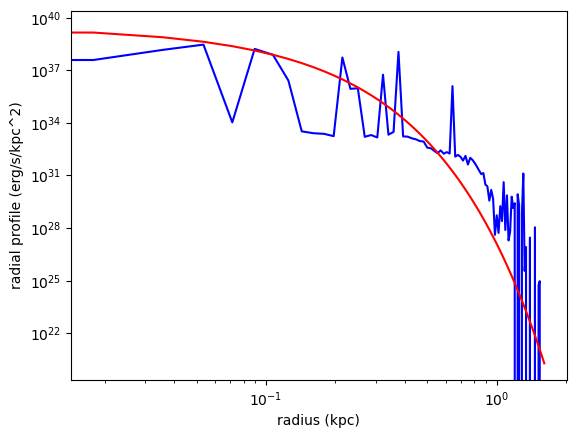

In [8]:
fig4, ax4 = plt.subplots()
ax4.loglog(r, rad_profile, color='blue')
ax4.loglog(r, I, color="red")
ax4.set(xlabel='radius (kpc)', ylabel='radial profile (erg/s/kpc^2)')

In [79]:
print(half_light)
print(half_light_actual)

4.4063957129576814e+38
2.8662226638794997e+38


In [80]:
print(max(rad_profile))

2.8662226638794997e+38


In [82]:
print(index)

3


In [83]:
0.19274333s

0.05358492582117702
